In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats

from pyuvdata import UVData, UVBeam
import linsolve
import hera_cal as hc
from scipy import signal
import hera_pspec as hp

from collections import OrderedDict as odict
from hera_cal.abscal import fill_dict_nans
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)

/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, 

## Load metadata 

In [2]:
path='/home/ntsikelelo/Simulated_data_files/'
# load the metadata
model = hc.io.HERAData("/home/ntsikelelo/Simulated_data_files/UVH5_files/Model_data_complete.uvh5")
freqs = model.freq_array[0]
delays=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e9
bl_lens=np.array([14.599999999902579, 163.23296235725184])



## Wegde line parameters

In [3]:
b_14=14.6
c=3e8
b_28=2*b_14
tau_14=(b_14/c)*1e9
tau_28=(b_28/c)*1e9



m=(tau_28-tau_14)/(b_28-b_14)
c=tau_14-m*b_14
c_=-c
base_line=np.linspace(bl_lens[0], bl_lens[-1],32)
wedge_line=m*base_line+c
wedge_line_=-m*base_line+c_

## residual for complete sky model

In [4]:
cal_wedge_fft_complete=np.load(path+"cal_wedge_redcal_no_filter_complete_no_filter.npy")
mdl_wedge_fft=np.load(path+"mdl_wedge_redcal_no_filter_complete_no_filter.npy")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


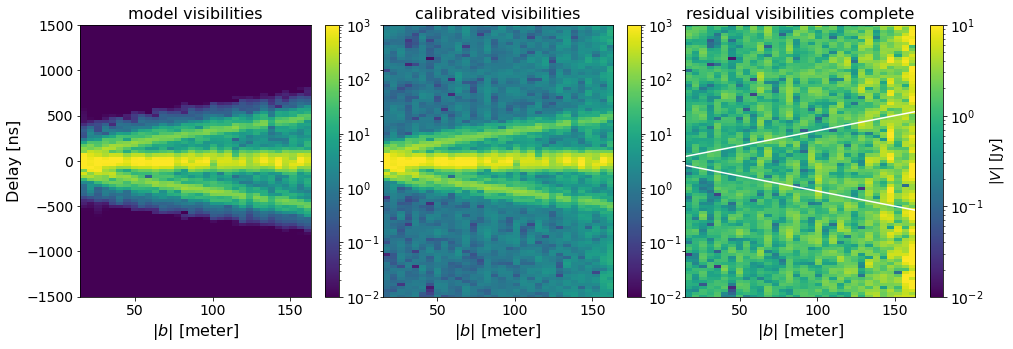

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft[0,:, :].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'Delay [ns]', fontsize=16)
ax.set_title("model visibilities", fontsize=16)
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)


ax = axes[1]
cax = ax.imshow(np.abs(cal_wedge_fft_complete[0,:, :].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("calibrated visibilities", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete)[0,:, :].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e1, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("residual visibilities complete", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.set_yticklabels([])
fig.colorbar(cax, ax=ax, label=r"$|V|$ [Jy]")
plt.plot(base_line,wedge_line,'w')
plt.plot(base_line,wedge_line_,'w')


## residual for an incomplete sky model

In [6]:
cal_wedge_fft_incomplete=np.load(path+"cal_wedge_redcal_no_filter_incomplete_no_filter_baseline_cut.npy")
mdl_wedge_fft=np.load(path+"mdl_wedge_redcal_no_filter_complete_no_filter.npy")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


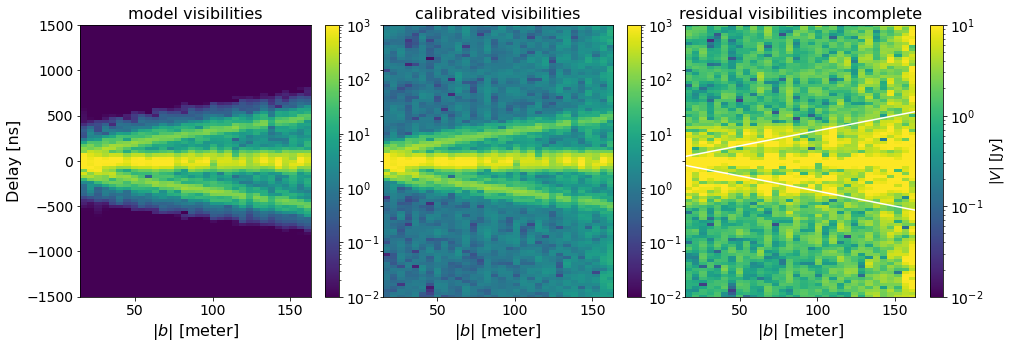

In [7]:


fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft[0,:, :].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'Delay [ns]', fontsize=16)
ax.set_title("model visibilities", fontsize=16)
# ax.grid()
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)


ax = axes[1]
cax = ax.imshow(np.abs(cal_wedge_fft_complete[0,:, :].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("calibrated visibilities", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_incomplete)[0,:, :].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e1, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])

ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("residual visibilities incomplete", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.set_yticklabels([])
# ax.grid()
fig.colorbar(cax, ax=ax, label=r"$|V|$ [Jy]")
plt.plot(base_line,wedge_line,'w')
plt.plot(base_line,wedge_line_,'w')

## residuals for DPSS filter 0.25mHz

In [8]:
cal_wedge_fft_filtered_baseline_cut_25=np.load(path+"cal_wedge_redcal_notch_filter_0.25_dssp_incomplete_with_filter_baseline_cut.npy")


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


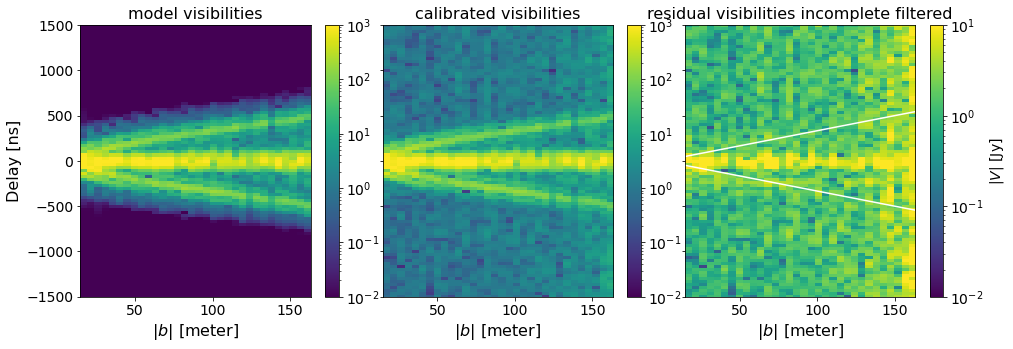

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft[0,:, :].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'Delay [ns]', fontsize=16)
ax.set_title("model visibilities", fontsize=16)
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)


ax = axes[1]
cax = ax.imshow(np.abs(cal_wedge_fft_filtered_baseline_cut_25[0,:, :].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("calibrated visibilities", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)


ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_filtered_baseline_cut_25)[0,:, :].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e1, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("residual visibilities incomplete filtered", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.set_yticklabels([])
fig.colorbar(cax, ax=ax, label=r"$|V|$ [Jy]")
plt.plot(base_line,wedge_line,'w')
plt.plot(base_line,wedge_line_,'w')


## residuals sqaured 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


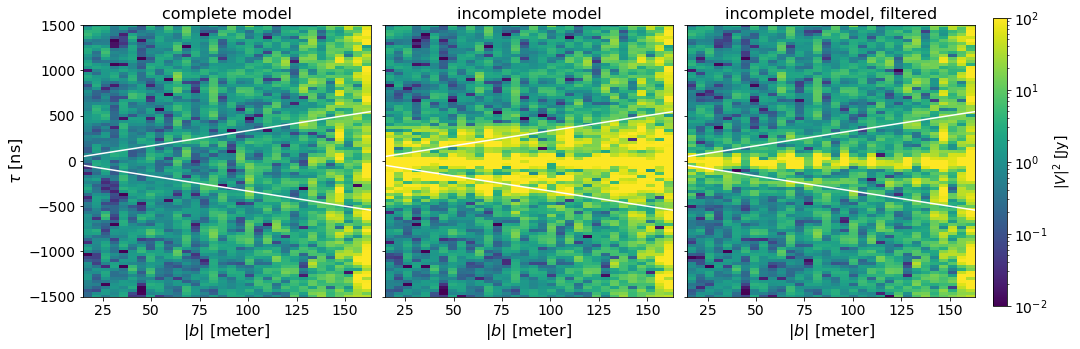

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete)[0,:, :].T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e2, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#cbar = fig.colorbar(cax, ax=ax)
#cbar.ax.tick_params(labelsize=12)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'$\tau$ [ns]', fontsize=16)
ax.set_title("complete model", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax = axes[1]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_incomplete)[0,:, :].T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e2, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("incomplete model", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_filtered_baseline_cut_25)[0,:, :].T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e2, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("incomplete model, filtered", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax.set_yticklabels([])
cbax = fig.add_axes([0.83, 0.1, 0.1, 0.8])
cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, label=r"$|V|^2$ [Jy]");


## Power spectrum for redundant baselines 

In [11]:
def JytomK(Jy, f0=163e6):
    """Convert Jansky to mK

    Args:
        Jy (float): brightness in Jy
        f0 (float): frequency in Hz

    Returns:
        float: brightness temperature in mK
    """

    # wavelength in m
    c=3.0e8
    lam = c / f0

    # flux density in W/m^2/Hz
    S = Jy * 1e-26
    kb=1.38064852e-23
    # temperature in K
    T = S * lam ** 2 / (2 * kb)

    # rettourn temperature in mK
    return T * 1e3

def power_spectrum(V,baseline):
    window = signal.blackmanharris(delays.shape[0])
    comso=hp.conversions.Cosmo_Conversions(Om_l=0.7,H0=70,Om_c=0.3)
    c=3e8
    f1=165.0e6
    f0=1420.0e6
    lambda_0=c/f0
    lambda_1=c/f1

    z=(lambda_1-lambda_0)/lambda_0
    factor=comso.bl_to_kperp(z=z)
    theta=(lambda_1/baseline)
    Dc=comso.dRperp_dtheta(z)*theta
    df=((200-100)/1024.0)*1e6
    Beff=np.sum(window*df)
    Delta_D=comso.dRpara_df(z)*Beff
    k_par=comso.tau_to_kpara(z=z)*delays*1e-9
    k_per=factor*baseline
    theta_d=np.rad2deg(theta)
    Ae=theta_d**2
    

    steradian=(180.0/np.pi)**2 #degrees per steradian
    Omega= Ae/steradian
    df=((200-100)/1024.0)*1e6
    V_mk=JytomK(Jy=V,f0=175e6)
    constant=((Dc**2*Delta_D)/(Beff))*(1/(Omega*Beff))
    P=V_mk**2*constant*df**2
    return np.array(P)


In [12]:
cal_wedge_fft_filtered_baseline_cut_40=np.load(path+"cal_wedge_redcal_notch_filter_0.40_dssp_incomplete_with_filter_baseline_cut.npy")
cal_wedge_fft_filtered_baseline_cut_60=np.load(path+"cal_wedge_redcal_notch_filter_0.60_dssp_incomplete_with_filter_baseline_cut.npy")
cal_wedge_fft_filtered_baseline_cut_Gaussian=np.load(path+"cal_wedge_redcal_no_filter_incomplete_Gaussian_filter_baseline_cut.npy")


In [14]:
s=118
e=126


baseline=14.6 ## meters
comso=hp.conversions.Cosmo_Conversions(Om_l=0.7,H0=70,Om_c=0.3)
c=3e8
f1=165.0e6
f0=1420.0e6
lambda_0=c/f0
lambda_1=c/f1
window = signal.blackmanharris(delays.shape[0])
z=(lambda_1-lambda_0)/lambda_0
factor=comso.bl_to_kperp(z=z)
theta=(lambda_1/baseline)
Dc=comso.dRperp_dtheta(z)*theta
df=((200-100)/1024.0)*1e6
Beff=np.sum(window*df)
Delta_D=comso.dRpara_df(z)*Beff
k_par=comso.tau_to_kpara(z=z)*delays*1e-9
k_per=factor*baseline
k=np.sqrt(k_par**2+np.ones(k_par.shape)*k_per**2)

theta_d=np.rad2deg(theta)
Ae=theta_d**2


steradian=(180.0/np.pi)**2 #degrees per steradian
Omega= Ae/steradian

res_wedge_unfiltered_complete=mdl_wedge_fft-cal_wedge_fft_complete
res_wedge_unfiltered=mdl_wedge_fft-cal_wedge_fft_incomplete
res_25_blc=mdl_wedge_fft-cal_wedge_fft_filtered_baseline_cut_25
res_40_blc=mdl_wedge_fft-cal_wedge_fft_filtered_baseline_cut_40
res_60_blc=mdl_wedge_fft-cal_wedge_fft_filtered_baseline_cut_60
res_Gaussian=mdl_wedge_fft-cal_wedge_fft_filtered_baseline_cut_Gaussian

V0=np.mean(np.abs(res_wedge_unfiltered_complete[s:e,:,:]),axis=0)
V1=np.mean(np.abs(res_wedge_unfiltered[s:e,:,:]),axis=0)  
V_25=np.mean(np.abs(res_25_blc[s:e,:,:]),axis=0)   
V_40=np.mean(np.abs(res_40_blc[s:e,:,:]),axis=0)
V_60=np.mean(np.abs(res_60_blc[s:e,:,:]),axis=0)
V_G=np.mean(np.abs(res_Gaussian[s:e,:,:]),axis=0)

bl=np.linspace(bl_lens[0],bl_lens[-1],32)

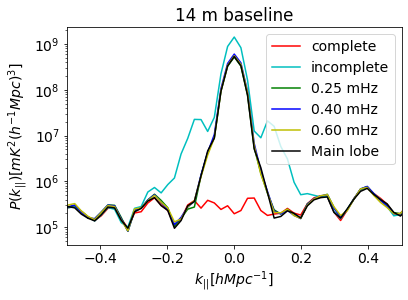

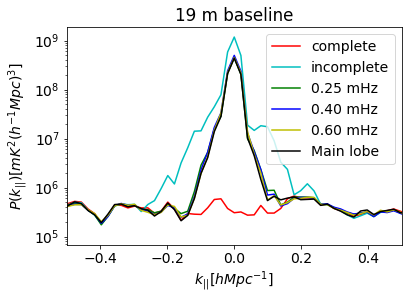

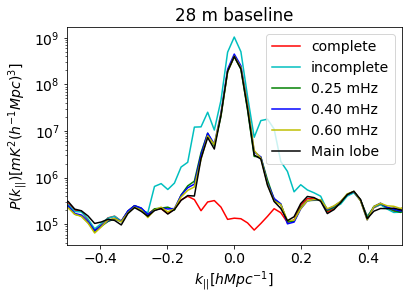

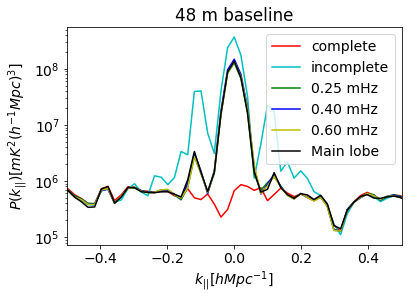

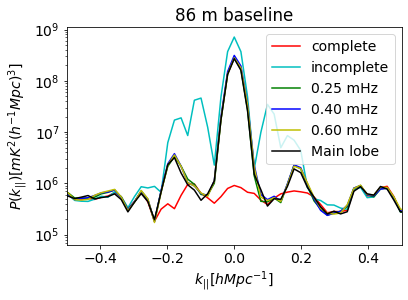

In [15]:
res_wedge_unfiltered_complete=mdl_wedge_fft-cal_wedge_fft_complete
res_wedge_unfiltered=mdl_wedge_fft-cal_wedge_fft_incomplete
for n in range(5):
    i=2**n-1
    plt.figure()
    plt.semilogy(k_par,power_spectrum(V0,bl[i])[i,:],'r',label="complete")
    plt.semilogy(k_par,power_spectrum(V1,bl[i])[i,:],'c',label="incomplete")
    plt.semilogy(k_par,power_spectrum(V_25,bl[i])[i,:],'g',label="0.25 mHz")
    plt.semilogy(k_par,power_spectrum(V_40,bl[i])[i,:],'b',label="0.40 mHz")
    plt.semilogy(k_par,power_spectrum(V_60,bl[i])[i,:],'y',label="0.60 mHz")
    plt.semilogy(k_par,power_spectrum(V_G,bl[i])[i,:],'k',label="Main lobe")
#     plt.axvline(x= kpar_baseline_wegde[i], color = 'b', label = 'axvline - full height')
#     plt.axvline(x= -kpar_baseline_wegde[i], color = 'b', label = 'axvline - full height')
    #plt.semilogy(delays,np.mean(np.mean(np.abs(res_Gaussian[s:e,:,:]),axis=0),axis=0),label="Gaussian filter")
    plt.xlabel("$k_{||}[h Mpc^{-1}]$")
    plt.ylabel("$P(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
    plt.xlim([-0.5,0.5])
    plt.legend()
    plt.title(str(int(bl[i]))+" m baseline")


